Students:

- Benedictus Kent Rachmat
- Dana Aubakirova
- Diego Andres Torres Guarin
- Stefano Bavaro

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [3]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import time as ts

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [3]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [4]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 4


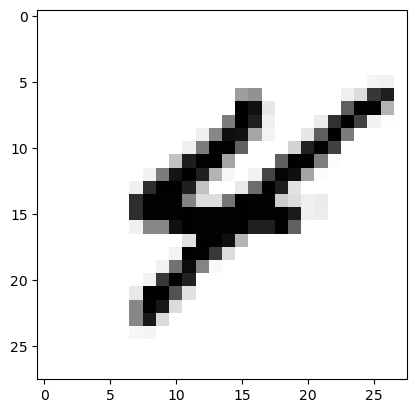

In [5]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [6]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None # backptr is the list of tensors that are inputs to this tensor
        
    def zero_grad(self):
        """
        Set the gradient of this tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            print(gradient, self.data)
            print(gradient.shape, self.data.shape)
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            # if the gradient is not None, accumulate it
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, (float, int)):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            # store the gradient if given
            self.gradient = g

        # if not given, use the current value of the gradient
        if self.d is not None:
            # d is the function that propagates the gradient
            # to the inputs of the tensor
            self.d(self.backptr, self.gradient)

        if self.backptr is not None:
            for o in self.backptr:
                # if the input is a tensor and requires a gradient
                # then call its backward method
                # sometimes inputs can be np.arrays so we need to check that
                if isinstance(o, Tensor) and not isinstance(o, Parameter):
                    if o.require_grad:
                        o.backward()
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [7]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [8]:
# Here is an exemple with the ReLU
def relu(x):
    # simple implementation of relu in numpy
    # notice the difference between np.maximum and np.max
    # np.maximum returns a new array with the maximum value at each position
    # np.max returns the maximum value of the array
    # we implicitly use broadcasting with 0
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        # the gradient of relu is 1 if x > 0 and 0 otherwise
        # normally x.data > 0 is a boolean mask, but by 
        # multiplying it with a float, we get a float mask
        x.accumulate_gradient(g * (x.data > 0))

In [9]:
def tanh(x):
    # trivial implementation of tanh
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    if x.require_grad:
        # the derivative of tanh is 1 - tanh(x)**2
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [10]:
def affine_transform(W, b, x):
    # Compute the output of the affine transformation
    v = W.data@x.data + b.data
    
    # Create a new tensor to store the output of the affine transformation and set its requires_grad attribute based on whether any of the inputs require gradients
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))  
    # Set the backward function of the output tensor to be the backward_affine_transform function, which computes the gradients needed for backpropagation
    output.d = backward_affine_transform
    # Set the backptr attribute of the output tensor to store the inputs, so that the backward function can access them
    output.backptr = [W, b, x]
    
    # Return the output tensor
    return output

def backward_affine_transform(backptr, g):
    # Unpack the inputs from the backptr argument
    W, b, x = backptr    
    
    # If the weight matrix requires gradients, compute and accumulate the gradient
    if W.require_grad:
        if isinstance(x, Tensor):
            x_val = x.data
        else:
            x_val = x
        
        if len(x_val.shape) == 1:
            x_val = x_val.reshape(-1, 1)

        if len(g.shape) == 1:
            g = g.reshape(-1, 1)
            
        # Compute the gradient of the weight matrix using the chain rule
        W.accumulate_gradient(g@x_val.T)

    # If the bias vector requires gradients, compute and accumulate the gradient
    if b.require_grad:
        b.accumulate_gradient(g)
        
    # If the input data requires gradients, compute and accumulate the gradient
    if isinstance(x, Tensor) and x.require_grad:
        x.accumulate_gradient(W.data.T@g)


In [11]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    # we subtract the maximum value to avoid numerical issues
    b = np.max(x)
    e = np.exp(x-b)
    return e/np.sum(e)

def nll(x, gold):
    # Compute the negative log-likelihood of the gold label
    # we assume that x is the vector of scores, before softmax
    # and gold is the index of the gold label
    # we flatten x because it has shape (-1,1)
    data = -x.data.flatten()[gold] + np.log(np.sum(np.exp(x.data.flatten())))

    output = Tensor(data, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]

    return output


def backward_nll(backptr, g):
    x, gold = backptr

    if x.require_grad:
        # we use the identity matrix np.eye to 
        # get the one-hot vector of the gold label
        one_hot_gold = np.eye(len(x.data.flatten()))[gold]

        # we use the _softmax function defined above
        softmax_pred = _softmax(x.data.flatten())
        x.accumulate_gradient(g*(-one_hot_gold+softmax_pred).reshape(-1, 1))
    

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [12]:
class Module:
    def __init__(self):
        pass
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret
    
    def __call__(self, x):
        return self.forward(x)

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [13]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), np.sqrt(6. / (W.shape[0] + W.shape[1])), W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / W.shape[1]), np.sqrt(6. / W.shape[1]), W.shape)

In [14]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [15]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,1)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [19]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs, lr=0.01, momentum=0.):
    result = []
    
    # Iterate over the specified number of epochs
    for epoch in range(n_epochs):
        start = ts.time()
        
        print('EPOCH:', epoch+1)
        
        # Initialize variables to track training loss and accuracy
        train_loss = 0
        train_good = 0
        
        # Iterate over training data
        for x, y in zip(*train_data):
            # Forward pass through the network to obtain outputs
            output = network(x.reshape(-1, 1))
            
            # Calculate loss and backpropagate gradients
            loss = nll(output, y)
            loss.backward(1)
            optimizer.step()
            optimizer.zero_grad()

            # Update training loss and accuracy
            train_loss += loss.data
            if np.argmax(output.data) == y:
                train_good += 1

        # Calculate and print training loss and accuracy
        train_loss_res = (train_loss/len(train_data[1]))[0]
        train_good_res = train_good/len(train_data[1])
        print('Training loss', train_loss_res)
        print('Training accuracy', train_good_res)

        # Initialize variables to track validation loss and accuracy
        dev_loss = 0
        dev_good = 0
        
        # Iterate over validation data
        for x, y in zip(*dev_data):
            # Forward pass through the network to obtain outputs
            output = network(x.reshape(-1,1))
            
            # Calculate validation loss and accuracy
            loss = nll(output, y)
            dev_loss += loss.data
            if np.argmax(output.data) == y:
                dev_good += 1
        
        # Calculate and print validation loss and accuracy
        val_loss = (dev_loss/len(dev_data[1]))[0]
        val_good = dev_good/len(dev_data[1])
        print('Validation loss', val_loss)
        print('Validation accuracy', val_good)
        end = ts.time()

        # Append results for the epoch to the result list
        result.append({
        'train_loss_res': train_loss_res,
        'train_good_res': train_good_res,
        'val_loss': val_loss,
        'val_good':val_good,
        'lr' : lr,
        'momentum':momentum,
        'epochs':epoch+1,
        'time': end-start
        }) 

    # Return the list of results for all epochs
    return result

In [20]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01) # 0.01 is the learning rate

training_loop(network, optimizer, train_data, dev_data, n_epochs=5);

EPOCH: 1
Training loss 0.3769517389766714
Training accuracy 0.89138
Validation loss 0.30129405208078525
Validation accuracy 0.9148
EPOCH: 2
Training loss 0.31030389874614955
Training accuracy 0.91186
Validation loss 0.2887355687466374
Validation accuracy 0.9205
EPOCH: 3
Training loss 0.29800998104661963
Training accuracy 0.91576
Validation loss 0.2839615233667181
Validation accuracy 0.9223
EPOCH: 4
Training loss 0.29100280436489434
Training accuracy 0.9178
Validation loss 0.28154623134502765
Validation accuracy 0.9221
EPOCH: 5
Training loss 0.28615165311459373
Training accuracy 0.91896
Validation loss 0.280166821298488
Validation accuracy 0.9233


After you finished the linear network, you can move to a deep network!

In [21]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):
        # initialize input projection weights and bias
        self.input_proj = self.give_weight_matrix(dim_input, hidden_dim, 0)
        self.input_bias = self.give_bias(hidden_dim, 0)

        # initialize hidden layer weights and biases
        self.W = ModuleList([self.give_weight_matrix(hidden_dim, hidden_dim, i) for i in range(1, n_layers)])
        self.b = ModuleList([self.give_bias(hidden_dim, i) for i in range(1, n_layers)])
        
        # initialize output projection weights and bias
        self.output_proj = self.give_weight_matrix(hidden_dim, dim_output, n_layers)
        self.output_bias = self.give_bias(dim_output, n_layers)
        
        self.init_parameters()

    def init_parameters(self):
        # set bias to 0
        zero_init(self.input_bias.data)
        zero_init(self.output_bias.data)
        for b in self.b:
            zero_init(b.data)

        # set weights using Xavier initialization
        glorot_init(self.input_proj.data)
        glorot_init(self.output_proj.data)
        for W in self.W:
            glorot_init(W.data)

    def forward(self, x):
        # input projection and activation
        x = affine_transform(self.input_proj, self.input_bias, x)
        x = relu(x)

        # hidden layers and activation
        for W, b in zip(self.W, self.b):
            x = affine_transform(W, b, x)
            x = relu(x)

        # output projection and activation
        x = affine_transform(self.output_proj, self.output_bias, x)
        return x

    # static method to create weight matrix
    @staticmethod
    def give_weight_matrix(dim_input, dim_output, n):
        # create a weight matrix with given dimensions and name
        W = Parameter(np.ndarray((dim_output, dim_input)), name=f"W_{n}")
        return W
    
    # static method to create bias vector
    @staticmethod
    def give_bias(dim, n):
        # create a bias vector with given dimension and name
        W = Parameter(np.ndarray((dim, 1)), name=f"b_{n}")
        return W

In [23]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5, lr=0.01, momentum=0.);

EPOCH: 1
Training loss 0.24568490909409615
Training accuracy 0.9244
Validation loss 0.11493836116048659
Validation accuracy 0.9647
EPOCH: 2
Training loss 0.11109028421862091
Training accuracy 0.96544
Validation loss 0.10413517039532087
Validation accuracy 0.9695
EPOCH: 3
Training loss 0.07646055680879432
Training accuracy 0.97624
Validation loss 0.10050170205715657
Validation accuracy 0.9725
EPOCH: 4
Training loss 0.0594637573673536
Training accuracy 0.98104
Validation loss 0.10448572784364635
Validation accuracy 0.9723
EPOCH: 5
Training loss 0.04768114044271388
Training accuracy 0.98442
Validation loss 0.10427225867377989
Validation accuracy 0.9734


## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [26]:
class MomentumSGD:
    def __init__(self, params, lr=0.1, momentum=0.1):
        self.params = params  
        self.velocities = [np.zeros_like(p.data) for p in params]  
        self.lr = lr  
        self.momentum = momentum  

    def step(self):
        # Update parameters using momentum SGD
        for p, velocity in zip(self.params, self.velocities):
            velocity[:] = self.momentum * velocity + p.gradient  # update velocity using gradient and momentum
            p.data[:] = p.data - self.lr * velocity  # update parameter using velocity and learning rate
        
    def zero_grad(self):
        # Set gradients to zero for all parameters
        for p in self.params:
            p.zero_grad()


In [27]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = MomentumSGD(network.parameters(), 0.001, momentum=0.3)

training_loop(network, optimizer, train_data, dev_data, n_epochs=20, lr=0.001, momentum=0.3);

EPOCH: 1
Training loss [0.24787806]
Training accuracy 0.92328
Validation loss [0.1285585]
Validation accuracy 0.9619
EPOCH: 2
Training loss [0.11850497]
Training accuracy 0.9645
Validation loss [0.11971927]
Validation accuracy 0.9645
EPOCH: 3
Training loss [0.08214556]
Training accuracy 0.97446
Validation loss [0.11153357]
Validation accuracy 0.9683
EPOCH: 4
Training loss [0.06429762]
Training accuracy 0.98004
Validation loss [0.117301]
Validation accuracy 0.9681
EPOCH: 5
Training loss [0.05352035]
Training accuracy 0.98256
Validation loss [0.12524923]
Validation accuracy 0.968


## Experiments

We perform a grid search on the hyperparameters of learning rate and momentum to try to find the best model for this dataset. The whole process takes more than 4 hours and was run on [Kaggle](https://www.kaggle.com/code/kentrachmat/deep-learning), here we only present some of the results.

In [24]:
GRID_SEARCH = False # Change this variable to True to perform grid search on hyperparameters

In [25]:
dim_input = 28*28
dim_output = 10

# Values of learning rate and momentum to try
lr = [0.01, 0.001]
momentum = [0.1, 0.5, 0.9]

if GRID_SEARCH:
    for l in lr:
        for m in momentum:
            results_final = []
            print(f"------------- lr : {l}, momentum : {m} -------------")
            network = DeepNetwork(dim_input, dim_output, 100, 2)
            optimizer = MomentumSGD(network.parameters(), l, momentum=m)

            results_final = training_loop(network, optimizer, train_data, dev_data, 20, l ,m)
            with open(f'results_lr{l}_m{m}.json', 'w') as f:
                json.dump(results_final, f, indent=4)
else:
    print('No grid search')

No grid search


In [1]:
## Normally we load the file with the results, but because
## we can only upload 2 files to the grader, we have to
## hardcode the results as a python list of dictionaries
# filename = "results"
# with open(f'results/{filename}.json', 'r') as f:
#     results = json.load(f) 

In [4]:
results = [
    {
        "train_loss_res": 0.39261911308118164,
        "train_good_res": 0.88002,
        "val_loss": 0.1515754919819915,
        "val_good": 0.9534,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 1,
        "time": 206.7070927619934
    },
    {
        "train_loss_res": 0.13709419546531199,
        "train_good_res": 0.95872,
        "val_loss": 0.11868630833421037,
        "val_good": 0.9653,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 2,
        "time": 206.03615927696228
    },
    {
        "train_loss_res": 0.09142965733750485,
        "train_good_res": 0.97248,
        "val_loss": 0.10697868785610355,
        "val_good": 0.969,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 3,
        "time": 207.13710069656372
    },
    {
        "train_loss_res": 0.06580074231886514,
        "train_good_res": 0.98022,
        "val_loss": 0.09882142651979878,
        "val_good": 0.9727,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 4,
        "time": 206.8383469581604
    },
    {
        "train_loss_res": 0.04899687619789033,
        "train_good_res": 0.98544,
        "val_loss": 0.0999299215246295,
        "val_good": 0.9737,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 5,
        "time": 207.34105896949768
    },
    {
        "train_loss_res": 0.039058753912343806,
        "train_good_res": 0.98814,
        "val_loss": 0.10572351743291317,
        "val_good": 0.9735,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 6,
        "time": 206.76092410087585
    },
    {
        "train_loss_res": 0.0317729710904202,
        "train_good_res": 0.99048,
        "val_loss": 0.09668681525505485,
        "val_good": 0.9756,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 7,
        "time": 205.49588465690613
    },
    {
        "train_loss_res": 0.024256482225097645,
        "train_good_res": 0.99218,
        "val_loss": 0.09975158523965445,
        "val_good": 0.9773,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 8,
        "time": 204.08982014656067
    },
    {
        "train_loss_res": 0.024371853972208854,
        "train_good_res": 0.9917,
        "val_loss": 0.110873150125139,
        "val_good": 0.9752,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 9,
        "time": 205.98715019226074
    },
    {
        "train_loss_res": 0.019517850651642847,
        "train_good_res": 0.99394,
        "val_loss": 0.10197423670137996,
        "val_good": 0.9768,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 10,
        "time": 205.17707991600037
    },
    {
        "train_loss_res": 0.016703211369944192,
        "train_good_res": 0.99462,
        "val_loss": 0.10282817876536862,
        "val_good": 0.977,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 11,
        "time": 205.79412317276
    },
    {
        "train_loss_res": 0.014238706347287935,
        "train_good_res": 0.99536,
        "val_loss": 0.1022682592539514,
        "val_good": 0.9794,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 12,
        "time": 205.0164008140564
    },
    {
        "train_loss_res": 0.013255294490580775,
        "train_good_res": 0.99566,
        "val_loss": 0.10874537639898868,
        "val_good": 0.9758,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 13,
        "time": 205.0952422618866
    },
    {
        "train_loss_res": 0.014948590821683306,
        "train_good_res": 0.99476,
        "val_loss": 0.11513820517956058,
        "val_good": 0.9761,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 14,
        "time": 204.77868843078613
    },
    {
        "train_loss_res": 0.011150164125009644,
        "train_good_res": 0.99632,
        "val_loss": 0.12218411950493212,
        "val_good": 0.9761,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 15,
        "time": 205.32685089111328
    },
    {
        "train_loss_res": 0.011891350264355562,
        "train_good_res": 0.99634,
        "val_loss": 0.1035797829086826,
        "val_good": 0.9795,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 16,
        "time": 205.03003454208374
    },
    {
        "train_loss_res": 0.008007118350960463,
        "train_good_res": 0.9975,
        "val_loss": 0.1044148996144876,
        "val_good": 0.9799,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 17,
        "time": 204.80429244041443
    },
    {
        "train_loss_res": 0.009980587130261134,
        "train_good_res": 0.99682,
        "val_loss": 0.11705389749883989,
        "val_good": 0.9781,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 18,
        "time": 205.7939646244049
    },
    {
        "train_loss_res": 0.007220345513356497,
        "train_good_res": 0.99772,
        "val_loss": 0.11278441646959536,
        "val_good": 0.9796,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 19,
        "time": 203.0489740371704
    },
    {
        "train_loss_res": 0.003658122615273071,
        "train_good_res": 0.99894,
        "val_loss": 0.12379242807226244,
        "val_good": 0.9787,
        "lr": 0.001,
        "momentum": 0.3,
        "epochs": 20,
        "time": 204.89975571632385
    }
]

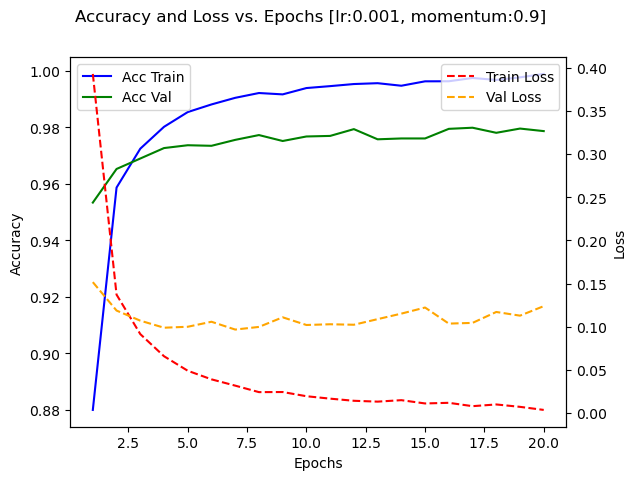

In [5]:
accuracy_train = [x['train_good_res'] for x in results]
accuracy_val = [x['val_good'] for x in results]
loss_train = [x['train_loss_res'] for x in results]
loss_val = [x['val_loss'] for x in results]
epochs = [x['epochs'] for x in results]

# create the plot
fig, ax1 = plt.subplots()

# create the first y-axis for accuracy
ax1.plot(epochs, accuracy_train, label='Acc Train', color='blue')
ax1.plot(epochs, accuracy_val, label='Acc Val', color='green')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', labelcolor='black')

# create the second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, loss_train, label='Train Loss', color='red', linestyle='--')
ax2.plot(epochs, loss_val, label='Val Loss', color='orange', linestyle='--')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', labelcolor='black')

# add a title and legend
fig.suptitle('Accuracy and Loss vs. Epochs [lr:0.001, momentum:0.9]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# save the plot
plt.show()
